In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

import featuretools as ft

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [2]:
bureau_balance = help_tool.csv_download(r'Archive\home-credit-default-risk\bureau_balance.csv')
help_tool.first_look(bureau_balance)

Dataset has 27299925 observations and 3 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_BUREAU,int64,0,0.0
MONTHS_BALANCE,int64,0,0.0
STATUS,object,0,0.0


In [3]:
def bureau_balance_data_clean(df):
    df['Closed'] = np.where(df['STATUS'] == 'Closed', 1, 0)

    df['STATUS'] = df['STATUS'].replace({'C': 0, 'X': np.nan}).astype(float)
    df['STATUS'] = df['STATUS'].infer_objects(copy=False)
    return df

bureau_balance = bureau_balance_data_clean(bureau_balance)

The values in the STATUS column can be interpreted as follows:

0: No DPD (Days past due)</br>
1: DPD 1-30 days</br>
2: DPD 31-60 days</br>
3: DPD 61-90 days</br>
4: DPD 91-120 days</br>
5: DPD 121+ days</br>
C: Closed</br>
X: No loan for the month</br>

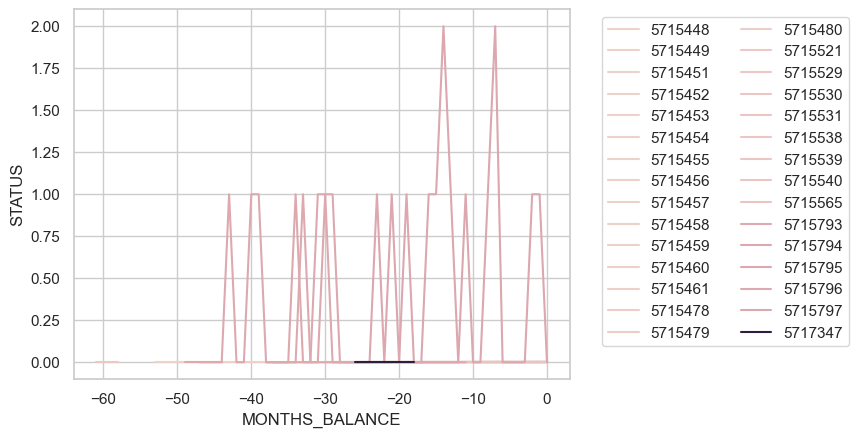

In [4]:
first_100_ids = bureau_balance['SK_ID_BUREAU'].drop_duplicates().head(30)
filtered_bureau_balance = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin(first_100_ids)]

sns.lineplot(data=filtered_bureau_balance, x='MONTHS_BALANCE', y='STATUS', hue='SK_ID_BUREAU', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.show()

In [5]:
bureau_balance_sample = bureau_balance.sample(n=100000, random_state=42)

In [6]:
#help_visuals.distribution_check(bureau_balance_sample[['MONTHS_BALANCE', 'STATUS']])

In [7]:
#help_visuals.distribution_check(bureau_balance[bureau_balance['MONTHS_BALANCE'] == 0][['STATUS']])

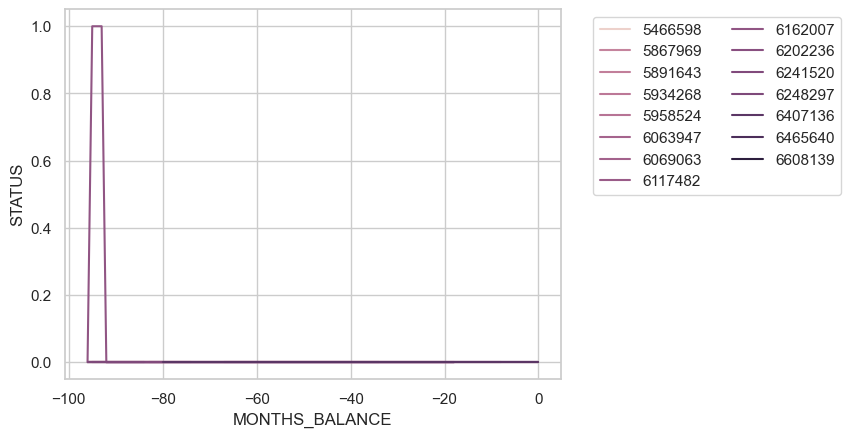

In [8]:
long_term_users = bureau_balance[bureau_balance['MONTHS_BALANCE'] == bureau_balance['MONTHS_BALANCE'].min()]['SK_ID_BUREAU'].drop_duplicates().sample(15, random_state=42)
filtered_bureau_balance = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin(long_term_users)]

sns.lineplot(data=filtered_bureau_balance, x='MONTHS_BALANCE', y='STATUS', hue='SK_ID_BUREAU', legend='full'
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.show()

In [9]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,Closed
0,5715448,0,0.0,0
1,5715448,-1,0.0,0
2,5715448,-2,0.0,0
3,5715448,-3,0.0,0
4,5715448,-4,0.0,0


# bureau

In [10]:
bureau = help_tool.csv_download(r'Archive\home-credit-default-risk\bureau.csv')
help_tool.first_look(bureau)

Dataset has 1716428 observations and 17 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_CURR,int64,0,0.0
SK_ID_BUREAU,int64,0,0.0
CREDIT_ACTIVE,object,0,0.0
CREDIT_CURRENCY,object,0,0.0
DAYS_CREDIT,int64,0,0.0
CREDIT_DAY_OVERDUE,int64,0,0.0
DAYS_CREDIT_ENDDATE,float64,105553,6.1
DAYS_ENDDATE_FACT,float64,633653,36.9
AMT_CREDIT_MAX_OVERDUE,float64,1124488,65.5
CNT_CREDIT_PROLONG,int64,0,0.0


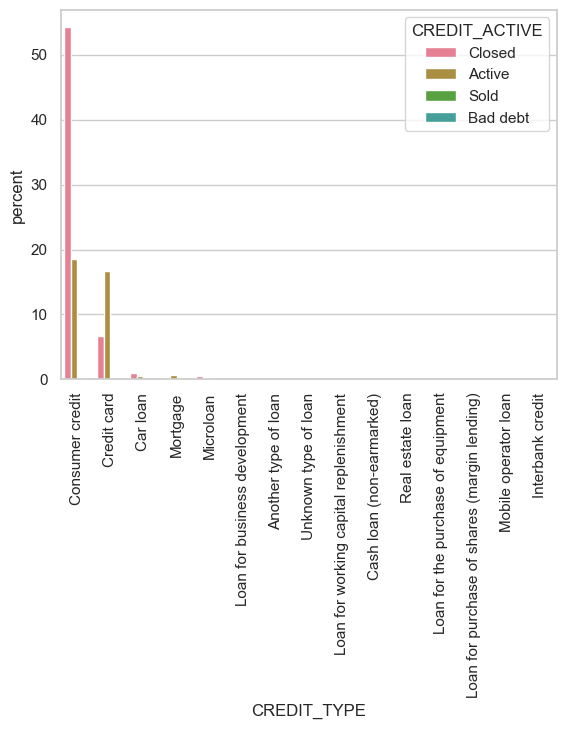

In [11]:
sns.countplot(bureau, x="CREDIT_TYPE", hue="CREDIT_ACTIVE", stat="percent", 
              order = bureau['CREDIT_TYPE'].value_counts().to_frame().reset_index()['CREDIT_TYPE'].to_list())

plt.xticks(rotation=90)
plt.show()

In [12]:
def bureau_clean(df):
    df['CREDIT_CURRENCY'] = df['CREDIT_CURRENCY'].str.lstrip('currency ').astype(int)
    df.loc[~df['CREDIT_TYPE'].isin(['Credit card', 'Consumer credit']), 'CREDIT_TYPE'] = 'Other'


    # Assigning Credit activity to preferable vs not preferable on numerical scale
    df.loc[df['CREDIT_ACTIVE'] == 'Closed', 'CREDIT_ACTIVE'] = 2
    df.loc[df['CREDIT_ACTIVE'] == 'Active', 'CREDIT_ACTIVE'] = 1
    df.loc[df['CREDIT_ACTIVE'] == 'Sold', 'CREDIT_ACTIVE'] = -1
    df.loc[df['CREDIT_ACTIVE'] == 'Bad debt', 'CREDIT_ACTIVE'] = -2

    df['CREDIT_ACTIVE'] = df['CREDIT_ACTIVE'].astype(int)


    df['CREDIT_CURRENCY'] = df['CREDIT_CURRENCY'].infer_objects(copy=False)

bureau_clean(bureau)

In [13]:
duckdb.query("""
WITH shape AS (
    SELECT DISTINCT A.SK_ID_BUREAU AS A_SK_ID_BUREAU, B.SK_ID_BUREAU AS B_SK_ID_BUREAU
    FROM bureau A 
    LEFT JOIN bureau_balance B
    ON A.SK_ID_BUREAU = B.SK_ID_BUREAU
)
SELECT 
    SUM(CASE WHEN B_SK_ID_BUREAU IS NULL THEN 1 ELSE 0 END) AS NULL_VAL,
    SUM(CASE WHEN B_SK_ID_BUREAU IS NOT NULL THEN 1 ELSE 0 END) AS NOT_NULL_VAL
FROM shape
""").df()


,NULL_VAL,NOT_NULL_VAL
0,942074.0,774354.0


In [14]:
bureau[['Application_Duration', 'Update_Duration', 'Remaining_Duration']] = duckdb.query("""  
    SELECT
    (COALESCE(DAYS_ENDDATE_FACT, 0) - COALESCE(DAYS_CREDIT, 0)) AS Application_Duration,
    (COALESCE(DAYS_CREDIT_UPDATE, 0) - COALESCE(DAYS_CREDIT, 0)) AS Update_Duration,
    (COALESCE(DAYS_CREDIT_ENDDATE, 0) - COALESCE(DAYS_CREDIT, 0)) AS Remaining_Duration

    FROM bureau
  """).to_df()

In [15]:
bureau.drop(columns=bureau.filter(like='DAYS', axis=1).columns.to_list(), inplace = True)

In [16]:
bureau.filter(like='AMT_CREDIT', axis=1)

,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE
0,NaN,91323.00,0.0,NaN,0.0
1,NaN,225000.00,171342.0,NaN,0.0
2,NaN,464323.50,NaN,NaN,0.0
3,NaN,90000.00,NaN,NaN,0.0
4,77674.5,2700000.00,NaN,NaN,0.0
...,...,...,...,...,...
1716423,0.0,11250.00,11250.0,0.0,0.0
1716424,5476.5,38130.84,0.0,0.0,0.0
1716425,NaN,15570.00,NaN,NaN,0.0
1716426,NaN,36000.00,0.0,0.0,0.0


In [17]:
bureau[['RATIO_SUM_DEBT', 'RATION_SUM_LIMIT', 'RATION_SUM_OVERDUE']] = duckdb.query("""  
    SELECT
    (AMT_CREDIT_SUM / AMT_CREDIT_SUM_DEBT) AS RATIO_SUM_DEBT,
    (AMT_CREDIT_SUM / AMT_CREDIT_SUM_LIMIT) AS RATION_SUM_LIMIT,
    (AMT_CREDIT_SUM / AMT_CREDIT_SUM_OVERDUE) AS RATION_SUM_OVERDUE,

    FROM bureau
  """).to_df()

In [18]:
# bureau_balance_gr = duckdb.query("""
#              WITH 

#              bureau_balance_grouped as (
#                 SELECT 
#                      SK_ID_BUREAU, 
#                      MIN(MONTHS_BALANCE) - MAX(MONTHS_BALANCE) AS History_Lenght_Month, 
#                      SUM(CASE WHEN STATUS = 1 THEN 1 ELSE 0 END) AS ONE_MONTHS_MISSED_COUNT,
#                      SUM(CASE WHEN STATUS = 2 THEN 1 ELSE 0 END) AS TWO_MONTHS_MISSED_COUNT,
#                      SUM(CASE WHEN STATUS = 3 THEN 1 ELSE 0 END) AS TREE_MONTHS_MISSED_COUNT,
#                      SUM(CASE WHEN STATUS = 4 THEN 1 ELSE 0 END) AS FOUR_MONTHS_MISSED_COUNT,
#                      SUM(CASE WHEN STATUS = 5 THEN 1 ELSE 0 END) AS FIVE_MONTHS_MISSED_COUNT,
#                      SUM(CASE WHEN STATUS > 0 THEN 1 ELSE 0 END) AS MONTHS_MISSED_COUNT          
             
#                 FROM bureau_balance
#                 GROUP BY SK_ID_BUREAU
#              )


#              SELECT * 
#              FROM bureau A 
#              LEFT JOIN bureau_balance_grouped B
#              ON A.SK_ID_BUREAU = B.SK_ID_BUREAU


#               """).df()

In [19]:
# bureau_balance_gr

In [20]:
# bureau_balance_gr.dtypes

# Light XGB

In [107]:
#bureau_balance_gr['CREDIT_ACTIVE'].value_counts() / bureau_balance_gr['CREDIT_ACTIVE'].value_counts().max() * 100

In [108]:
#bureau_balance_gr[bureau_balance_gr['CREDIT_ACTIVE'].isin(['Sold', 'Bad debt'])]

In [109]:
#bureau_balance_gr[(bureau_balance_gr['CREDIT_ACTIVE'] != 'Active') & (~bureau_balance_gr['MONTHS_MISSED_COUNT'].isna())]['CREDIT_ACTIVE'].value_counts() /489622 * 100

In [110]:
# bureau_bad_sold = bureau_balance_gr[bureau_balance_gr['CREDIT_ACTIVE'] != 'Active'].drop(columns=['SK_ID_CURR', 'SK_ID_BUREAU'])

# bureau_bad_sold.loc[bureau_bad_sold['CREDIT_ACTIVE'] == 'Closed', 'CREDIT_Bad_Sold'] = 0
# bureau_bad_sold.loc[bureau_bad_sold['CREDIT_ACTIVE'] != 'Closed', 'CREDIT_Bad_Sold'] = 1

# bureau_bad_sold.drop(columns=['CREDIT_ACTIVE', 'DAYS_ENDDATE_FACT'], inplace=True)

In [111]:
# bureau_bad_sold['CREDIT_Bad_Sold'].value_counts()

In [112]:
# y = bureau_bad_sold['CREDIT_Bad_Sold']
# X = bureau_bad_sold.drop(columns=['CREDIT_Bad_Sold'])

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
# # Identify categorical and numerical columns
# categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# # Preprocessing for numerical data
# numerical_transformer = StandardScaler()

# # Preprocessing for categorical data
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# # Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

# params = {
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'boosting_type': 'gbdt',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

# # Define the model
# model = LGBMClassifier(**params, n_estimators=100)

# # Create and evaluate the pipeline
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', model)
# ])

# pipeline.fit(X_train, y_train)

# # Predict on the test set
# y_pred = pipeline.predict(X_test)
# y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [114]:
# # # Evaluate the model
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# print(f"Precision: {precision}")
# print(f"accuracy: {accuracy}")
# print(f"recall: {recall}")
# print(f"ROC AUC: {roc_auc}")


In [115]:
# # Extract the preprocessing step and get feature names
# preprocessor.fit(X_train)
# onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
# all_columns = numerical_features + onehot_columns.tolist()

# # Extract feature importances from the trained model
# feature_importances = model.feature_importances_

# # Combine feature names and their importances into a DataFrame
# feature_importance_df = pd.DataFrame({
#     'Feature': all_columns,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# print(feature_importance_df)

In [116]:
# bureau_balance_gr

# Feature Engineering

In [40]:
bureau.filter(like='RATIO', axis=1).var()

RATIO_SUM_DEBT        4.621600e+08
RATION_SUM_LIMIT      6.457094e+08
RATION_SUM_OVERDUE    8.249427e+09
dtype: float64

In [46]:
es = ft.EntitySet(id='bureau_data')

es = es.add_dataframe(dataframe_name='bureau',
                      dataframe=bureau,
                      index='SK_ID_BUREAU')

es = es.add_dataframe(dataframe_name='bureau_balance',
                      dataframe=bureau_balance.drop(columns='MONTHS_BALANCE'),
                      make_index=True,
                      index='index')

es = es.add_relationship(parent_dataframe_name='bureau',
                         parent_column_name='SK_ID_BUREAU',
                         child_dataframe_name='bureau_balance',
                         child_column_name='SK_ID_BUREAU')

bureau_feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name='bureau',
                                      agg_primitives=['mean', 'sum', 'count', 'std', 'max', 'min']
                                      )


bureau_feature_matrix = bureau_feature_matrix.reset_index()
bureau_feature_matrix.shape

c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\entityset\entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x000001F5D1817100> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function max at 0x000001F5D1816700> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ).agg(to_ag

(1716428, 30)

In [47]:
bureau_feature_matrix = duckdb.query("""  
  SELECT A.*, B.Duration
  FROM bureau_feature_matrix A 
  LEFT JOIN (
    SELECT SK_ID_BUREAU, MAX(MONTHS_BALANCE) - MIN(MONTHS_BALANCE) AS Duration
    FROM bureau_balance
    GROUP BY SK_ID_BUREAU
    ) B ON A.SK_ID_BUREAU = B.SK_ID_BUREAU
  """).to_df()

In [49]:
bureau_feature_matrix.dtypes

SK_ID_BUREAU                      int64
SK_ID_CURR                        int64
CREDIT_ACTIVE                     int64
CREDIT_CURRENCY                   int64
CREDIT_DAY_OVERDUE                int64
AMT_CREDIT_MAX_OVERDUE          float64
CNT_CREDIT_PROLONG                int64
AMT_CREDIT_SUM                  float64
AMT_CREDIT_SUM_DEBT             float64
AMT_CREDIT_SUM_LIMIT            float64
AMT_CREDIT_SUM_OVERDUE          float64
CREDIT_TYPE                    category
AMT_ANNUITY                     float64
Application_Duration            float64
Update_Duration                   int64
Remaining_Duration              float64
RATIO_SUM_DEBT                  float64
RATION_SUM_LIMIT                float64
RATION_SUM_OVERDUE              float64
COUNT(bureau_balance)             int64
MAX(bureau_balance.Closed)      float64
MAX(bureau_balance.STATUS)      float64
MEAN(bureau_balance.Closed)     float64
MEAN(bureau_balance.STATUS)     float64
MIN(bureau_balance.Closed)      float64


In [83]:
bureau_feature_matrix.head()

,index,SK_ID_BUREAU,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_DAY_OVERDUE,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,RATIO_SUM_DEBT,RATION_SUM_LIMIT,RATION_SUM_OVERDUE,COUNT(bureau_balance),MAX(bureau_balance.STATUS),MEAN(bureau_balance.STATUS),MIN(bureau_balance.STATUS),STD(bureau_balance.STATUS),SUM(bureau_balance.STATUS),Duration
0,0,6536900,441082,1,1,0,0.0,0,2929500.0,2626532.235,...,1.115349,NaN,NaN,10,0,0.0,0,0.0,0.0,9
1,1,6538789,278016,1,1,0,NaN,0,1349343.0,NaN,...,NaN,NaN,NaN,23,<NA>,NaN,<NA>,NaN,0.0,22
2,2,6538814,310097,2,1,0,NaN,0,900000.0,0.000,...,NaN,NaN,NaN,34,0,0.0,0,0.0,0.0,33
3,3,6539067,257104,1,1,0,NaN,0,180000.0,164268.000,...,1.095770,NaN,NaN,5,<NA>,NaN,<NA>,NaN,0.0,4
4,4,6539230,414342,1,1,0,NaN,0,486000.0,490072.500,...,0.991690,NaN,NaN,44,0,0.0,0,0.0,0.0,43


In [84]:
variances = bureau_feature_matrix.drop(columns=['CREDIT_TYPE']).var()
zero_variances = variances[(variances == 0) | variances.isna()].index.tolist()

bureau_feature_matrix[zero_variances]#.drop_duplicates()

""
0
1
2
3
4
...
1716423
1716424
1716425
1716426


In [62]:
bureau_feature_matrix.drop(columns=zero_variances, inplace = True)

In [86]:
bureau_feature_matrix.shape

(1716428, 27)

In [87]:
bureau_feature_matrix

,index,SK_ID_BUREAU,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_DAY_OVERDUE,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,RATIO_SUM_DEBT,RATION_SUM_LIMIT,RATION_SUM_OVERDUE,COUNT(bureau_balance),MAX(bureau_balance.STATUS),MEAN(bureau_balance.STATUS),MIN(bureau_balance.STATUS),STD(bureau_balance.STATUS),SUM(bureau_balance.STATUS),Duration
0,0,6536900,441082,1,1,0,0.00,0,2929500.0,2626532.235,...,1.115349,NaN,NaN,10,0,0.0,0,0.0,0.0,9
1,1,6538789,278016,1,1,0,NaN,0,1349343.0,NaN,...,NaN,NaN,NaN,23,<NA>,NaN,<NA>,NaN,0.0,22
2,2,6538814,310097,2,1,0,NaN,0,900000.0,0.000,...,NaN,NaN,NaN,34,0,0.0,0,0.0,0.0,33
3,3,6539067,257104,1,1,0,NaN,0,180000.0,164268.000,...,1.095770,NaN,NaN,5,<NA>,NaN,<NA>,NaN,0.0,4
4,4,6539230,414342,1,1,0,NaN,0,486000.0,490072.500,...,0.991690,NaN,NaN,44,0,0.0,0,0.0,0.0,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,1716423,6676092,341253,2,1,0,NaN,0,225000.0,0.000,...,NaN,NaN,NaN,0,<NA>,NaN,<NA>,NaN,0.0,<NA>
1716424,1716424,6676097,341253,2,1,0,6871.77,0,76545.0,0.000,...,NaN,NaN,NaN,0,<NA>,NaN,<NA>,NaN,0.0,<NA>
1716425,1716425,6676113,123079,1,1,0,0.00,0,135000.0,0.000,...,NaN,NaN,NaN,0,<NA>,NaN,<NA>,NaN,0.0,<NA>
1716426,1716426,6676123,123079,1,1,0,0.00,0,13500.0,0.000,...,NaN,1.0,NaN,0,<NA>,NaN,<NA>,NaN,0.0,<NA>


# Feature Engineering II

In [93]:
application_train_sized = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')[['SK_ID_CURR', 'TARGET']]

In [103]:
es = ft.EntitySet(id='bureau_data')

es = es.add_dataframe(dataframe_name='application_train_sized',
                      dataframe=application_train_sized,
                      index='SK_ID_CURR')

es = es.add_dataframe(dataframe_name='bureau_feature_matrix',
                      dataframe=bureau_feature_matrix,
                      make_index=True,
                      index='index'
                      )

es = es.add_relationship(parent_dataframe_name='application_train_sized',
                         parent_column_name='SK_ID_CURR',
                         child_dataframe_name='bureau_feature_matrix',
                         child_column_name='SK_ID_CURR')

top_level_bureau_feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name='application_train_sized',
                                      agg_primitives=['mean', 'sum', 'count', 'std', 'max', 'min']
                                      )


top_level_bureau_feature_matrix = top_level_bureau_feature_matrix.reset_index()
top_level_bureau_feature_matrix.shape

c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\entityset\entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\entityset\entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, make_index
  warnings.warn(
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x000001F5D1817100> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)
c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The 

(307511, 118)

In [104]:
variances = top_level_bureau_feature_matrix.var()
zero_variances = variances[(variances == 0) | variances.isna()].index.tolist()

top_level_bureau_feature_matrix.drop(columns=zero_variances, inplace = True)
top_level_bureau_feature_matrix.shape

In [106]:
top_level_bureau_feature_matrix.var()

SK_ID_CURR                                                10565820148.159698
TARGET                                                              0.074212
COUNT(bureau_feature_matrix)                                       20.215805
MAX(bureau_feature_matrix.AMT_ANNUITY)                   264876227952.149994
MAX(bureau_feature_matrix.AMT_CREDIT_MAX_OVERDUE)        135397192044.474976
                                                                ...         
SUM(bureau_feature_matrix.RATIO_SUM_DEBT)                   664524568.805097
SUM(bureau_feature_matrix.Remaining_Duration)               169002541.910925
SUM(bureau_feature_matrix.STD(bureau_balance.STATUS))               0.203093
SUM(bureau_feature_matrix.SUM(bureau_balance.STATUS))             254.058362
SUM(bureau_feature_matrix.Update_Duration)                    8825013.442509
Length: 118, dtype: Float64

# Light XGB and feature selection

In [123]:
top_level_bureau_feature_matrix['TARGET'].value_counts() / top_level_bureau_feature_matrix['TARGET'].count() *100

TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64

In [117]:
y = top_level_bureau_feature_matrix['TARGET']
X = top_level_bureau_feature_matrix.drop(columns=['TARGET', 'SK_ID_CURR'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Bundle preprocessing for numerical data
preprocessor = numerical_transformer

# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Define the model parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Initialize the model
model = LGBMClassifier(**params, n_estimators=100)

# Fit the model on the transformed training data
model.fit(X_train_transformed, y_train)

# Extract feature importances from the trained model
feature_importances = model.feature_importances_

# Combine feature names and their importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                                               Feature  Importance
65           MIN(bureau_feature_matrix.RATIO_SUM_DEBT)         167
25   MEAN(bureau_feature_matrix.AMT_CREDIT_MAX_OVER...         122
26          MEAN(bureau_feature_matrix.AMT_CREDIT_SUM)         108
30    MEAN(bureau_feature_matrix.Application_Duration)         103
33           MEAN(bureau_feature_matrix.CREDIT_ACTIVE)         102
..                                                 ...         ...
100      SUM(bureau_feature_matrix.CNT_CREDIT_PROLONG)           0
39   MEAN(bureau_feature_matrix.MIN(bureau_balance....           0
14   MAX(bureau_feature_matrix.MAX(bureau_balance.S...           0
16   MAX(bureau_feature_matrix.MIN(bureau_balance.S...           0
56            MIN(bureau_feature_matrix.CREDIT_ACTIVE)           0

[116 rows x 2 columns]


In [142]:
# # Evaluate the model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision}")
print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"ROC AUC: {roc_auc}")

Precision: 0.12268121590023383
accuracy: 0.6046859502788482
recall: 0.636088098605779
ROC AUC: 0.6641495544399749


In [152]:
feature_importance_df[feature_importance_df['Feature'].str.contains('RATIO_SUM_DEBT')]
#[feature_importance_df['Importance'] == 0]

,Feature,Importance
65,MIN(bureau_feature_matrix.RATIO_SUM_DEBT),167
88,STD(bureau_feature_matrix.RATIO_SUM_DEBT),86
42,MEAN(bureau_feature_matrix.RATIO_SUM_DEBT),74
111,SUM(bureau_feature_matrix.RATIO_SUM_DEBT),50
19,MAX(bureau_feature_matrix.RATIO_SUM_DEBT),48


In [170]:
feature_importance_df[feature_importance_df['Importance'] > 0]

,Feature,Importance
65,MIN(bureau_feature_matrix.RATIO_SUM_DEBT),167
25,MEAN(bureau_feature_matrix.AMT_CREDIT_MAX_OVER...,122
26,MEAN(bureau_feature_matrix.AMT_CREDIT_SUM),108
30,MEAN(bureau_feature_matrix.Application_Duration),103
33,MEAN(bureau_feature_matrix.CREDIT_ACTIVE),102
...,...,...
114,SUM(bureau_feature_matrix.SUM(bureau_balance.S...,2
77,STD(bureau_feature_matrix.CNT_CREDIT_PROLONG),2
104,SUM(bureau_feature_matrix.CREDIT_DAY_OVERDUE),2
10,MAX(bureau_feature_matrix.CREDIT_ACTIVE),1


In [178]:
feature_importance_df[['Operation', 'Original_Feature']] = feature_importance_df['Feature'].str.split('bureau_feature_matrix.', n=1, expand=True)

feature_importance_df['Original_Feature'] = feature_importance_df['Original_Feature'].str.rstrip(')')
feature_importance_df['Operation'] = feature_importance_df['Operation'].str.rstrip('(')


In [197]:
feature_to_drop = duckdb.query(""" 
SELECT Feature
FROM (
    SELECT 
        *,
        ROW_NUMBER() OVER (PARTITION BY Original_Feature ORDER BY Importance DESC) AS RowNumber
    FROM feature_importance_df
    WHERE Operation != 'STD'
    ) A 
    WHERE RowNumber != 1
""" ).to_df()

## Another round

In [203]:
y = top_level_bureau_feature_matrix['TARGET']
X = top_level_bureau_feature_matrix.drop(columns=(feature_to_drop['Feature'].to_list() + ['TARGET']))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [204]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Bundle preprocessing for numerical data
preprocessor = numerical_transformer

# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Define the model parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Initialize the model
model = LGBMClassifier(**params, n_estimators=100)

# Fit the model on the transformed training data
model.fit(X_train_transformed, y_train)

# Extract feature importances from the trained model
feature_importances = model.feature_importances_

# Combine feature names and their importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                                              Feature  Importance
5   MEAN(bureau_feature_matrix.AMT_CREDIT_MAX_OVER...         245
6          MEAN(bureau_feature_matrix.AMT_CREDIT_SUM)         236
21          MIN(bureau_feature_matrix.RATIO_SUM_DEBT)         235
10   MEAN(bureau_feature_matrix.Application_Duration)         166
41          STD(bureau_feature_matrix.RATIO_SUM_DEBT)         159
42      STD(bureau_feature_matrix.Remaining_Duration)         123
13          MEAN(bureau_feature_matrix.CREDIT_ACTIVE)         118
22      MIN(bureau_feature_matrix.Remaining_Duration)         111
17       MEAN(bureau_feature_matrix.RATION_SUM_LIMIT)         111
25          STD(bureau_feature_matrix.AMT_CREDIT_SUM)          98
19        MEAN(bureau_feature_matrix.Update_Duration)          95
7     MEAN(bureau_feature_matrix.AMT_CREDIT_SUM_DEBT)          90
45         STD(bureau_feature_matrix.Update_Duration)          89
16  MEAN(bureau_feature_matrix.MEAN(bureau_balance...          72
26     STD

In [209]:
# # Evaluate the model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision}")
print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"ROC AUC: {roc_auc}")

Precision: 0.12268121590023383
accuracy: 0.6046859502788482
recall: 0.636088098605779
ROC AUC: 0.6641495544399749
